In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Loading the agronomic characteristics for each agrocam images (determined in Extraction)
# (this csv file is the the one determined for the Master internship so this is just an exemple of how the selection work)
data_para = pd.read_csv("para_agro.csv")
data_para["time"] = [ti.date() for ti in pd.to_datetime(data_para["time"])]

In [35]:
# Comparaison between ground truth and between treatments
# This comparaison is done either using MAPE (to take into account time dynamics)
from sklearn.metrics import mean_absolute_percentage_error

# This comparaison is done either using test comparing means (that doesn't take into account time dynamics)
from scipy.stats import anderson # Normality (if normal : t-test, if not : mannwhitney/wilcoxon)

from scipy.stats import ttest_ind, ttest_rel # t-test_independant et non-independant respectively
from scipy.stats import mannwhitneyu, wilcoxon # same but not normal

## Pre-treatment

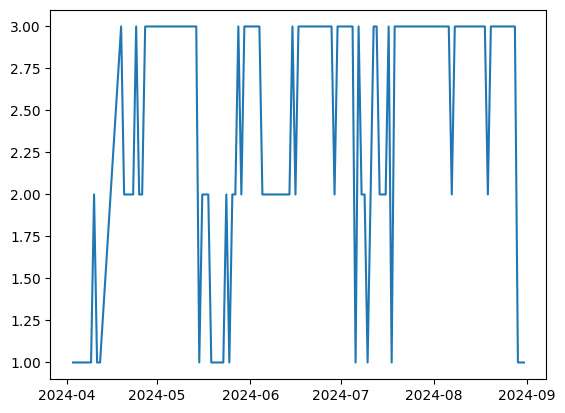

In [36]:
# Computing the number of sample per time
# For the different tools to work, we need 1 sample per treatment (so 3 sample per time)
num_of_time = np.unique(data_para["time"], return_counts=True)[1]
time = np.unique(data_para["time"], return_counts=True)[0]

plt.figure()
plt.plot(time,num_of_time)
plt.show()

In [ ]:
# Interpolating the missing values
date_range = pd.date_range(start="2024-04-24", end="2024-08-31", freq="D")

for cond in ["AVITI", "TVITI", "DVITI"]:
    data_para_temp = data_para[data_para["treatment"] == cond]
    data_para_temp.set_index("time",inplace=True)
    data_para_temp = data_para_temp.reindex(date_range)
    data_para_temp = data_para_temp.infer_objects(copy=False).interpolate(method="time", limit_direction='both')
    data_para_temp["treatment"] = data_para_temp["treatment"].fillna(cond)
    if cond == "AVITI":
        new_data_para = data_para_temp
    else:
        new_data_para = pd.concat([new_data_para, data_para_temp], axis=0)

new_data_para

C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\3324747299.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_para_temp = data_para_temp.infer_objects(copy=False).interpolate(method="time", limit_direction='both')
C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\3324747299.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_para_temp = data_para_temp.infer_objects(copy=False).interpolate(method="time", limit_direction='both')
C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\3324747299.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_para_temp = data_para_temp.infer_objects(copy=False).interpo

,treatment,dist_sup_tronc,H_vigne,P_vigne,Hue_vigne,Hue_rang
2024-04-24,AVITI,5.0,0.309259,0.803549,41.49,47.80
2024-04-25,AVITI,0.0,0.294444,0.753989,45.20,54.25
2024-04-26,AVITI,0.0,0.301852,0.792581,45.05,52.78
2024-04-27,AVITI,0.0,0.299074,0.739698,46.11,55.26
2024-04-28,AVITI,4.0,0.380556,0.807416,48.81,57.29
...,...,...,...,...,...,...
2024-08-27,DVITI,41.0,0.932407,-0.222073,46.70,29.46
2024-08-28,DVITI,56.0,0.929630,-0.208118,48.17,30.97
2024-08-29,DVITI,79.0,0.925000,-0.160821,57.52,135.63
2024-08-30,DVITI,83.0,0.903704,-0.190307,56.17,155.29


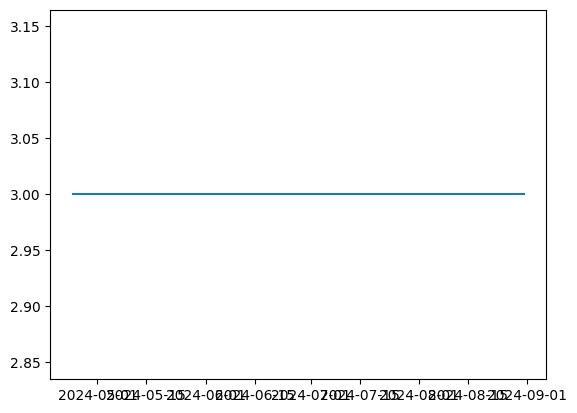

In [ ]:
# Verification
num_of_time = np.unique(new_data_para.index, return_counts=True)[1]
time = np.unique(new_data_para.index, return_counts=True)[0]

plt.figure()
plt.plot(time,num_of_time)
plt.show()

In [39]:
data_para = new_data_para

## Comparing treatment agains't other treatment

In [40]:
name_columns = ['H_vigne', 'P_vigne', 'Hue_vigne', 'Hue_rang']
name_treatment = ["AVITI", "DVITI", "TVITI"]
time_series = {}
for col in name_columns:
    time_series[col] = {}
    time_series[col]["AVITI"] = data_para.loc[data_para["treatment"] == "AVITI",col].to_numpy()
    time_series[col]["DVITI"] = data_para.loc[data_para["treatment"] == "DVITI",col].to_numpy()
    time_series[col]["TVITI"] = data_para.loc[data_para["treatment"] == "TVITI",col].to_numpy()

In [ ]:
pertinence_res_timeseries = pd.DataFrame([], columns=["AVITI vs DVITI", "AVITI vs TVITI", "TVITI vs DVITI"], 
                                         index=["MAPE", "stat_paired", "stat_not_paired"])

### Time (MAPE)

In [ ]:
# MAPE

for colum in name_columns:
    if colum == 'H_vigne':
        pertinence_res_timeseries.loc["MAPE","AVITI vs DVITI"] = []
        pertinence_res_timeseries.loc["MAPE","AVITI vs TVITI"] = []
        pertinence_res_timeseries.loc["MAPE","TVITI vs DVITI"] = []
    # NB : The order of AVITI first or DVITI first (same with the other) matters
    score = mean_absolute_percentage_error(time_series[colum]["AVITI"], time_series[colum]["DVITI"])
    if score > 1 :
        score = mean_absolute_percentage_error(time_series[colum]["DVITI"], time_series[colum]["AVITI"])
    pertinence_res_timeseries.loc["MAPE","AVITI vs DVITI"].append(score)

    score = mean_absolute_percentage_error(time_series[colum]["AVITI"], time_series[colum]["TVITI"])
    if score > 1 :
        score = mean_absolute_percentage_error(time_series[colum]["TVITI"], time_series[colum]["AVITI"])
    pertinence_res_timeseries.loc["MAPE","AVITI vs TVITI"].append(score)

    score = mean_absolute_percentage_error(time_series[colum]["TVITI"], time_series[colum]["DVITI"])
    if score > 1 :
        score = mean_absolute_percentage_error(time_series[colum]["DVITI"], time_series[colum]["TVITI"])
    pertinence_res_timeseries.loc["MAPE","TVITI vs DVITI"].append(score)


### No Time (Statistical test)

In [ ]:
for colum in name_columns:
    paired_test = ttest_rel
    test = ttest_ind
    for c in ["AVITI", "DVITI", "TVITI"]:
        test_normal = anderson(time_series[colum][c])
        if test_normal.statistic > test_normal.critical_values[2]:
            paired_test = wilcoxon
            test = mannwhitneyu
            print("not_normal")
            break
    if colum == 'H_vigne':
        pertinence_res_timeseries.loc["stat_not_paired",:] = [],[],[]
        pertinence_res_timeseries.loc["stat_paired",:] = [],[],[]
    pertinence_res_timeseries.loc["stat_not_paired","AVITI vs DVITI"].append(test(time_series[colum]["AVITI"], time_series[colum]["DVITI"]).pvalue)
    pertinence_res_timeseries.loc["stat_not_paired","AVITI vs TVITI"].append(test(time_series[colum]["AVITI"], time_series[colum]["TVITI"]).pvalue)
    pertinence_res_timeseries.loc["stat_not_paired","TVITI vs DVITI"].append(test(time_series[colum]["TVITI"], time_series[colum]["DVITI"]).pvalue)
    pertinence_res_timeseries.loc["stat_paired","AVITI vs DVITI"].append(paired_test(time_series[colum]["AVITI"], time_series[colum]["DVITI"]).pvalue)
    pertinence_res_timeseries.loc["stat_paired","AVITI vs TVITI"].append(paired_test(time_series[colum]["AVITI"], time_series[colum]["TVITI"]).pvalue)
    pertinence_res_timeseries.loc["stat_paired","TVITI vs DVITI"].append(paired_test(time_series[colum]["TVITI"], time_series[colum]["DVITI"]).pvalue)

not_normal
not_normal
not_normal
not_normal


### Representation

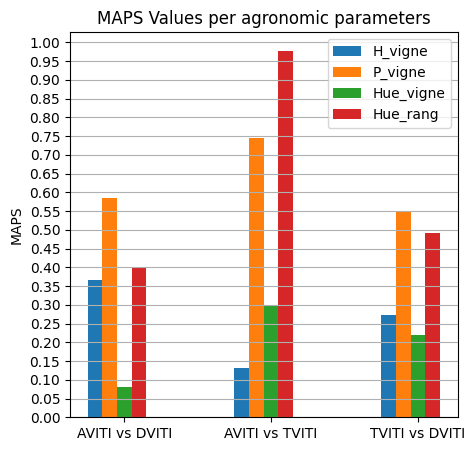

In [ ]:
cats = ["AVITI vs DVITI", "AVITI vs TVITI", "TVITI vs DVITI"] # categories

vals_h_vigne = [pertinence_res_timeseries.loc["MAPE", c][0] for c in cats]
vals_p_vigne = [pertinence_res_timeseries.loc["MAPE", c][1] for c in cats]
vals_Hue_vigne = [pertinence_res_timeseries.loc["MAPE", c][2] for c in cats]
vals_Hue_rang = [pertinence_res_timeseries.loc["MAPE", c][3] for c in cats]

# Bar width and x locations
w, x = 0.1, np.arange(len(cats))

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x - 0.2, vals_h_vigne, width=w, label='H_vigne')
ax.bar(x - 0.1, vals_p_vigne, width=w, label='P_vigne')
ax.bar(x + 0, vals_Hue_vigne, width=w, label='Hue_vigne')
ax.bar(x + 0.1, vals_Hue_rang, width=w, label='Hue_rang')

ax.grid(axis='y')
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_yticks(np.arange(0.0,1.05,0.05))
ax.set_ylabel('MAPE')
ax.set_title('MAPE Values per agronomic parameters')
ax.legend()
plt.rc('axes', axisbelow=True)
plt.show()

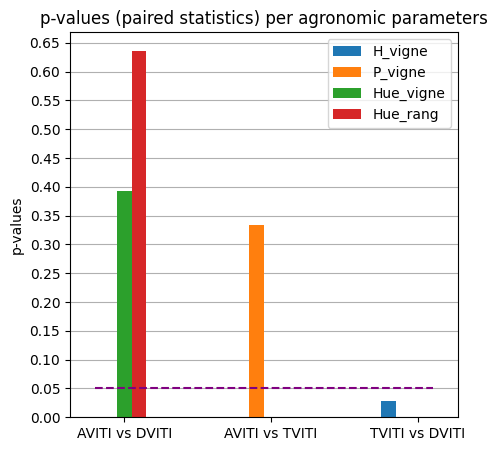

In [15]:

vals_h_vigne = [pertinence_res_timeseries.loc["stat_paired", c][0] for c in cats]
vals_p_vigne = [pertinence_res_timeseries.loc["stat_paired", c][1] for c in cats]
vals_Hue_vigne = [pertinence_res_timeseries.loc["stat_paired", c][2] for c in cats]
vals_Hue_rang = [pertinence_res_timeseries.loc["stat_paired", c][3] for c in cats]

# Bar width and x locations
w, x = 0.1, np.arange(len(cats))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hlines(0.05,-0.2,2.1, colors="purple", linestyles = "dashed")
ax.bar(x - 0.2, vals_h_vigne, width=w, label='H_vigne')
ax.bar(x - 0.1, vals_p_vigne, width=w, label='P_vigne')
ax.bar(x + 0, vals_Hue_vigne, width=w, label='Hue_vigne')
ax.bar(x + 0.1, vals_Hue_rang, width=w, label='Hue_rang')

ax.grid(axis='y')
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_yticks(np.arange(0.0,0.7,0.05))
ax.set_ylabel('p-values')
ax.set_title('p-values (paired statistics) per agronomic parameters')
ax.legend()
plt.rc('axes', axisbelow=True)
plt.show()

## Against ground truth time series

In [16]:
import os
import PIL.Image
import base64
import requests
from io import BytesIO
from typing import Optional, Union

def load_image(image: Union[str, "PIL.Image.Image"], timeout: Optional[float] = None, mode = ["RGB"]) -> "PIL.Image.Image":
    # Inspired by https://github.com/huggingface/transformers/blob/main/src/transformers/image_utils.py
    """
    Loads `image` to a PIL Image.

    Args:
        image (`str` or `PIL.Image.Image`):
            The image to convert to the PIL Image format.
        timeout (`float`, *optional*):
            The timeout value in seconds for the URL request.
        mode ('list'): (added)
            Image representation space ("RGB", "HSV", "LAB"...)

    Returns:
        `np.array`: A PIL Image converted in a np.array.
    """
    if isinstance(image, str):
        if image.startswith("http://") or image.startswith("https://"):
            # We need to actually check for a real protocol, otherwise it's impossible to use a local file
            # like http_huggingface_co.png
            image = PIL.Image.open(BytesIO(requests.get(image, timeout=timeout).content))
        elif os.path.isfile(image):
            image = PIL.Image.open(image)
        else:
            if image.startswith("data:image/"):
                image = image.split(",")[1]

            # Try to load as base64
            try:
                b64 = base64.decodebytes(image.encode())
                image = PIL.Image.open(BytesIO(b64))
            except Exception as e:
                raise ValueError(
                    f"Incorrect image source. Must be a valid URL starting with `http://` or `https://`, a valid path to an image file, or a base64 encoded string. Got {image}. Failed with {e}"
                )
    elif isinstance(image, PIL.Image.Image):
        image = image
    else:
        raise TypeError(
            "Incorrect format used for image. Should be an url linking to an image, a base64 string, a local path, or a PIL image."
        )
    image = PIL.ImageOps.exif_transpose(image)
    if len(mode) == 1:
        image_fin = image.convert(mode[0])
        image_fin = np.array(image_fin)
    else :
        for m in range(len(mode)) :
            if m==0:
                image_fin = image.convert(mode[m])
                image_fin = np.array(image_fin)
            else:
                image_temp = image.convert(mode[m])
                image_temp = np.array(image_temp)
                image_fin = np.append(image_fin, image_temp, axis=2)
    return image_fin

from pandas import read_csv
import numpy as np
from pandas import DataFrame, to_datetime

def data_loading(img_path="image_train/image", target_path="image_train/masque_final", for_train=False):
    """
    Load and store the Agrocam image and corresponding mask into a structured dataset for training or evaluation.

    This function extracts image paths and corresponding masks and associated metadata, and organizes
    the data into a structured DataFrame. It also calculates the distance between the top of the
    trunk and the bottom of the canopy for each image used to calculate the vegetation porosity.

    Parameters
    ----------
    img_path : str, optional
        Path to the directory containing input images. Default is "image".
    target_path : str, optional
        Path to the directory containing ground truth masks. Default is "masque_final".
    for_train : bool, optional
        If True, loads data for training (containing only 'all' mask). If False, loads all individual masks.
        Default is False.

    Returns
    -------
    img_data : pd.DataFrame
        DataFrame containing image paths, mask paths, treatments (aka treatments), day when the image is taken and calculated distances.
    """

    ## Loading metadata and listing images
    # Read the CSV file containing the metadata for each agrocam.
    data = read_csv("Liste_Agrocam.csv")
    # List all files in the image directory.
    all_image = os.listdir(img_path + "/")
    img_data = []

    ## Processing each image
    for i in all_image:
        # Skip non-image files.
        if not ((".jpg" in i) or (".png" in i)):
            continue
        
        ## Retreiving metadata
        # Extract camera ID from the filename.
        id_cam = i.split("_")[0]
        # Get the treatment for the camera ID.
        cond = data[data["ID Agrocam"] == id_cam][["treatment"]].values[0][0]
        # Extract date and time from the filename.
        times = i.split("_")

        ## Retreiving paths to the full image as well as canopy and trunk masks.
        # Remove the file extension for mask path construction.
        i_remove = i.replace(".jpg", "")
        # Retreiving path
        img = img_path + '/' + i
        sup = target_path + "/" + i_remove + "__zone_feuille_masque.png"
        tronc = target_path + "/" + i_remove + "__tronc_masque.png"

        ## Determining a general distance between the top of the trunk and the sheath for each treatment
        ## 1. Loading canopy and sheath masks 
        # Load the canopy and trunk masks in binary mode.
        sheath_img = load_image(sup, mode="1")
        tronc_img = load_image(tronc, mode="1")
        ## 2. Finding the top of the trunk and bottom of the canopy
        # Sum the values of pixels along the width to locate the width where the mask is.
        sum_sheath = np.sum(sheath_img, axis=1).reshape(1080)
        sum_tronc = np.sum(tronc_img, axis=1).reshape(1080)
        # Initialize variables to track the locations.
        sup_iter = len(sum_sheath) - 1
        one_iter_sup, one_iter_tronc = False, False
        for k in range(len(sum_sheath)):
            # Find the top of the trunk (first non-zero row encontered when coming from the top).
            if (sum_tronc[k] != 0) & (not one_iter_tronc):
                tronc_loc = k
                one_iter_tronc = True
            # Find the bottom of the canopy (first non-zero row encontered when coming from the bottom).
            if (sum_sheath[sup_iter] != 0) & (not one_iter_sup):
                sup_loc = sup_iter
                one_iter_sup = True
            sup_iter = sup_iter - 1
            # Exit the loop once both locations are found.
            if one_iter_sup & one_iter_tronc:
                break
        ## 3. Calculate the distance between the top of the trunk and the bottom of the canopy.
        dist_sup_tronc = tronc_loc - sup_loc
        # If the trunk top is not found, set distance to NaN.
        if tronc_loc == 0:
            dist_sup_tronc = np.nan

        ## Constructing data entries
        if for_train:
            # For training, only include the 'all' mask path (image with all the mask in one place).
            all = target_path + "/" + i_remove + "__all.png"
            l_add = [id_cam, times[1], times[2], cond, img, all, dist_sup_tronc]
        else:
            # For evaluation, include paths to all individual masks.
            feuille = target_path + "/" + i_remove + "__feuille_masque.png"
            inter = target_path + "/" + i_remove + "__interrang_masque.png"
            l_add = [id_cam, times[1], times[2], cond, img, feuille, inter, sup, tronc, dist_sup_tronc]
        img_data.append(l_add)

    ## Creating the DataFrame
    if for_train:
        # Create DataFrame with columns for training data.
        img_data = DataFrame(
            img_data,
            columns=["agroCam", "day", "time", "treatment", "image", 'all', 'dist_sup_tronc']
        )
    else:
        # Create DataFrame with columns for evaluation data.
        img_data = DataFrame(
            img_data,
            columns=["agroCam", "day", "time", "treatment", "image", "feuille", "inter", "sup", 'tronc', 'dist_sup_tronc']
        )
    # Combine day and time into a single datetime column.
    img_data["day_time"] = img_data["day"] + " " + img_data["time"]
    img_data['day_time'] = to_datetime(img_data['day_time'], format="%Y-%m-%d %H%M%S")
    # Drop the separate day and time columns.
    img_data = img_data.drop(columns=["day", "time"])

    ## Finalizing the distance measurement
    # Replace all the calculated distances with the mean distance per treatment.
    cat_par = np.unique(img_data['treatment'])
    mean_dist = img_data.groupby("treatment").mean('dist_sup_tronc')
    cat_dist = {m: np.float16(mean_dist.loc[m])[0] for m in cat_par}
    for cat in cat_dist:
        if cat_dist[cat] < 0:
            img_data.loc[img_data["treatment"] == cat, 'dist_sup_tronc'] = 0
        else:
            img_data.loc[img_data["treatment"] == cat, 'dist_sup_tronc'] = cat_dist[cat]

    return img_data

import copy
from pandas import DataFrame, to_datetime
from tqdm import tqdm

import numpy as np

def height_para(img):
    """
    Calculate the normalized height of the canopy vineyard in the image.

    This function determines the vertical span of non-zero pixels in the canopy mask,
    representing the height of the canopy.
    The result is then normalized by dividing by the total image height (1080 pixels).

    Parameters
    ----------
    img : numpy.ndarray
        Input canopy mask or image as either a 3D or a 2D numpy array.

    Returns
    -------
    height : float or numpy.nan
        Normalized height of the canopy (height / 1080).
        Returns `numpy.nan` if the image contains only zero pixels.
    """

    ## Summing pixel values across width (and channels)
    if len(img.shape) == 3 :
        # Sum pixel values along the width (axis=1) and then across channels (axis=1) if the input is a 3D array.
        sum_RGB = np.sum(img, axis=1)
        sum_RGB = sum_RGB.sum(axis=1)
    elif len(img.shape) == 2:
        # If the input is a 2D array, sum pixel values along the width (axis=1)
        sum_RGB = np.sum(img, axis=1)
    else :
        print("Incorrect dimension")

    ## Handling edge case: all-zero image
    # If the sum of all pixel values is zero, return NaN (no canopy detected).
    if sum_RGB.sum() == 0:
        return np.nan

    ## Finding the top of the canopy
    # Iterate from the bottom to the top of the image to find the highest non-zero row.
    for i in range(len(sum_RGB)):
        if sum_RGB[i] != 0:
            high = i  # Row index of the top of the canopy
            break
    
    ## Finding the bottom of the canopy
    # Iterate from the top to the bottom of the image to find the lowest non-zero row.
    for i in reversed(range(len(sum_RGB))):
        if sum_RGB[i] != 0:
            low = i  # Row index of the bottom of the canopy
            break

    ## Calculating and returning normalized height
    # Calculate the height as the difference between the top and bottom width 
    # normalized by the total image width (1080 pixels).
    return round(-(high - low) / 1080, 3)

# import numpy as np

def porosity_para(img_zone, img_enti, type_entity="sheath", corr=50):
    """
    Calculate the porosity of a plant canopy zone relative to the entire plant area.

    This function computes the porosity by substracting the area (number of pixel) of the canopy 
    by the area of the upper part of the image (determining using the trunc or the sheath). 
    It is then normalized by the area of the upper part of the image.

    Parameters
    ----------
    img_zone : numpy.ndarray
        3D or 2D array representing the trunc and sheath.
    img_enti : numpy.ndarray
        3D or 2D array representing the canopy.
    type_entity : strings
        Informing the type of mask the `img_zone` represent.
        Either the sheath mask ("sheath") or the trunk mask ("trunk").
    corr : int, optional
        Correction factor to adjust the lower boundary of the zone. Default is 50.

    Returns
    -------
    porosity : float or numpy.nan
        Porosity value (ratio of empty space to total zone area).
        Returns `numpy.nan` if either input image is all zeros.
    """
    
    ## Summing pixel values across width (and channels)
    if len(img_zone.shape) == 3 :
        # Sum pixel values along the width (axis=1) and then across channels (axis=1) if the input is a 3D array.
        sum_RGB = np.sum(img_zone, axis=1)
        sum_RGB = sum_RGB.sum(axis=1)
    elif len(img_zone.shape) == 2:
        # If the input is a 2D array, sum pixel values along the width (axis=1)
        sum_RGB = np.sum(img_zone, axis=1)
    else :
        print("Incorrect dimension")

    ## Handling edge case: all-zero image
    # If either image is all zeros, return NaN (no data to process).
    if img_zone.sum() == 0 or img_enti.sum() == 0:
        return np.nan

    ## Determining the mask of the upper part of the image using either the trunk or sheath mask.
    ## Find the bottom of the upper part of the image using the sheath mask or the trunk mask.
    if type_entity == "sheath" :
        # When using the sheath mask, we use the first non-zero row (for the bottom of the sheath).
        for i in reversed(range(len(sum_RGB))):
            if sum_RGB[i] != 0:
                low_zone = i
                break
        # Adjust the lower boundary of the zone using the correction factor.
        low_zone = low_zone + corr
    elif type_entity == "trunk":
        # When using the trunk mask, we use the first non-zero row (for the top of the trunk).
        for i in range(len(sum_RGB)):
            if sum_RGB[i] != 0:
                low_zone = i
                break
    else :
        print("Wrong entity name")
    ## Creating a mask for the upper zone by taking its bottom (determined earlier) and all the pixel to the top of the image.
    # Initialize a zero array for the zone mask.
    img_zone_plus = np.zeros((1080, 1920, 3))
    # Fill the zone mask up to the adjusted lower boundary.
    for i in range(1080):
        for j in range(1920):
            # Set pixels in the upper zone to 1.
            if i < low_zone:
                img_zone_plus[i, j, :] = 1
            # Binarize the entire plant image (set non-zero pixels to 1).
            if img_enti[i, j, :].sum() != 0:
                img_enti[i, j, :] = 1

    ## Calculating porosity
    # Subtract the binarized canopy mask from the upper zone mask to find empty spaces.
    img_z_e = img_zone_plus - img_enti
    # Calculate porosity as the ratio of empty space to total upper zone area.
    return round(img_z_e.sum() / img_zone_plus.sum(), 3)

# import numpy as np

def hue_para(ori_img,img):
    """
    Calculate the average hue channel intensity in order to caracterize the leaf color in the canopy 
    (if the canopy mask is used) and the state of the interrow (if the interrow mask is used).

    This function filters out black pixels (where R=G=B=0) and computes the mean intensity
    of the hue channel for the remaining pixels.

    Parameters
    ----------
    img : numpy.ndarray
        Input HSV image as a 3D numpy array (height × width × channels).

    Returns
    -------
    hue_mean : float or numpy.nan
        Mean intensity of the hue channel for non-black pixels, rounded to 2 decimal places.
        Returns `numpy.nan` if the image contains only black pixels.
    """

    ## Filtering out black pixels
    img = ori_img * img
    # Create a boolean mask where True indicates non-black pixels (R, G, and B all non-zero).
    filter = np.sum(img != [0, 0, 0], axis=2) == 3
    # Apply the filter.
    img = img[filter]
    # If no non-black pixels are found, return NaN.
    if filter.sum() == 0:
        return np.nan

    ## Calculating mean hue intensity
    # Extract the hue channel (first channel in HSV format in PIL formating).
    img_hue = [img[i][0] for i in range(img.shape[0])]
    # Calculate the mean hue intensity across all non-black pixels.
    img_hue = np.mean(img_hue)
    # Round the result to 2 decimals.
    return round(img_hue, 2)

def agro_para_extr(data, type_entity="sheath", save=False):
    """
    Extract agronomic parameters from Agrocam images and masks.

    This function loads image and mask data, then calculates four key agronomic parameters:
    vine height, vine porosity, inter-row greenness, and vine greenness.
    Results are stored in a DataFrame and optionally saved to CSV.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame in the format returned by the function `data_loading` with its default parameters.
    type_entity : strings
        Informing the type of mask used for determining the upper zone of the image.
    save : bool, optional
        If True, saves the results to a CSV file every 50 iterations and at the end.
        Default is False.

    Returns
    -------
    para_agro : pd.DataFrame
        DataFrame containing extracted agronomic parameters for each image:
        - time: Date of image capture
        - treatment: Experimental treatment
        - dist_sup_tronc: Distance between top of trunk and bottom of canopy
        - H_vigne: Vine height (normalized)
        - P_vigne: Vine porosity
        - Hue_vigne: Vine hue (HSV hue)
        - Hue_rang: Inter-row hue (HSV hue)
    """

    ## Loading and preparing data
    # Initialize a DataFrame to store extracted parameters.
    data['day_time'] = to_datetime(data['day_time'], format="%Y-%m-%d %H:%M:%S")
    para_agro = DataFrame({
        "time": data["day_time"].dt.date,
        "treatment": data["treatment"]
    })
    # Add the distance between top of trunk and bottom of canopy.
    para_agro["dist_sup_tronc"] = data["dist_sup_tronc"]
    # Initialize columns for agronomic parameters.
    para_agro["H_vigne"], para_agro["P_vigne"], para_agro["Hue_vigne"], para_agro["Hue_rang"] = 0, 0, 0, 0

    ## Extracting parameters for each image
    for i in tqdm(range(data.shape[0])):
        
        # Skip a specific problematic image.
        all_target = load_image(data.loc[i, "all"], mode=["L"])
        label = ["bck", "feuille", "inter", "sheath", "trunk"]
        all_classes = {i : 0 for i in label if i != "bck"}
        for o in range(1,len(label)):
            # Extract the predicted and target binary mask of the selected class
            mask = (all_target == o) * 1.0
            mask = np.expand_dims(mask, 2)
            all_classes[label[o]] = mask
        
        # Load original image in HSV color space used for hue calculation.
        ori_img = load_image(data.loc[i, "image"], mode=["HSV"])
        feuille_2 = copy.deepcopy(all_classes["feuille"])  # Create a copy for hue analysis
        
        ## Calculating agronomic parameters
        # Calculate vine height (normalized).
        para_agro.loc[i, "H_vigne"] = height_para(all_classes["feuille"])
        # Calculate vine porosity using the sheath mask or the trunk mask.
        para_agro.loc[i, "P_vigne"] = porosity_para(all_classes[type_entity], all_classes["feuille"], corr=data.loc[i, "dist_sup_tronc"])
        # Calculate inter-row mean hue.
        para_agro.loc[i, "Hue_rang"] = hue_para(ori_img, all_classes["inter"])
        # Calculate vine mean hue.
        para_agro.loc[i, "Hue_vigne"] = hue_para(ori_img, feuille_2)

        ## Periodically saving results
        # Save results to CSV every 50 iterations and at the end of processing.
        if ((i % 10 == 0) or (i == data.shape[0] - 1)) and save:
            para_agro.to_csv("Results/Agro_chara_vine.csv", index=False)

    return para_agro


In [50]:
# Generating the agronomic characteristics of images using ground truth mask
data_truth = data_loading(for_train=True)

data_para_field = agro_para_extr(data_truth)

data_para_field

C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\3382560581.py:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.5625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  img_data.loc[img_data["treatment"] == cat, 'dist_sup_tronc'] = cat_dist[cat]
  0%|          | 0/33 [00:00<?, ?it/s]C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\3382560581.py:441: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.281' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  para_agro.loc[i, "H_vigne"] = height_para(all_classes["feuille"])
C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\3382560581.py:443: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.824' has dtype incompatible w

,time,treatment,dist_sup_tronc,H_vigne,P_vigne,Hue_vigne,Hue_rang
0,2024-04-19,DVITI,75.5625,0.281,0.824,46.11,76.42
1,2024-05-01,DVITI,75.5625,0.348,0.696,47.14,71.81
2,2024-05-14,DVITI,75.5625,0.391,0.435,61.26,72.56
3,2024-05-28,DVITI,75.5625,0.329,0.479,74.78,91.78
4,2024-06-04,DVITI,75.5625,0.401,0.432,84.12,91.47
5,2024-06-15,DVITI,75.5625,0.421,0.232,76.54,121.65
6,2024-06-25,DVITI,75.5625,0.416,0.242,67.88,124.59
7,2024-07-05,DVITI,75.5625,0.653,0.273,62.25,72.81
8,2024-07-13,DVITI,75.5625,0.651,0.261,64.27,84.07
9,2024-07-25,DVITI,75.5625,0.919,0.291,47.84,33.46


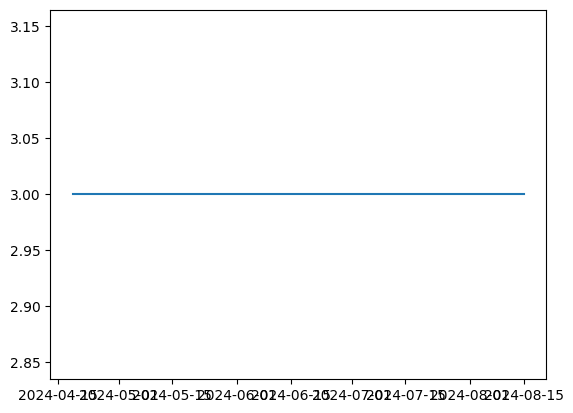

In [51]:
# Computing the number of sample per time
# For the different tools to work, we need 1 sample per treatment (so 3 sample per time)
num_of_time = np.unique(data_para_field["time"], return_counts=True)[1]
time = np.unique(data_para_field["time"], return_counts=True)[0]

plt.figure()
plt.plot(time,num_of_time)
plt.show()

In [52]:
# Interpolating for the date that aren't in the ground truth characteristics but in the predicted characteristics
date_range = pd.date_range(start="2024-04-19", end="2024-08-15", freq="D")

for cond in ["AVITI", "TVITI", "DVITI"]:
    data_para_temp = data_para_field[data_para_field["treatment"] == cond]
    data_para_temp.set_index("time",inplace=True)
    data_para_temp = data_para_temp.reindex(date_range)
    data_para_temp = data_para_temp.interpolate(method="time", limit_direction='both')
    data_para_temp["treatment"] = data_para_temp["treatment"].fillna(cond)
    if cond == "AVITI":
        new_data_para = data_para_temp
    else:
        new_data_para = pd.concat([new_data_para, data_para_temp], axis=0)

new_data_para

C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\1903938032.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_para_temp = data_para_temp.interpolate(method="time", limit_direction='both')
C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\1903938032.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_para_temp = data_para_temp.interpolate(method="time", limit_direction='both')
C:\Users\seiko\AppData\Local\Temp\ipykernel_23356\1903938032.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_para_temp = data_para_temp.interpolate(method="time", limit_direction='both')


,treatment,dist_sup_tronc,H_vigne,P_vigne,Hue_vigne,Hue_rang
2024-04-19,AVITI,0.0000,0.225000,0.926000,50.870000,61.310000
2024-04-20,AVITI,0.0000,0.231667,0.919667,50.712500,60.797500
2024-04-21,AVITI,0.0000,0.238333,0.913333,50.555000,60.285000
2024-04-22,AVITI,0.0000,0.245000,0.907000,50.397500,59.772500
2024-04-23,AVITI,0.0000,0.251667,0.900667,50.240000,59.260000
...,...,...,...,...,...,...
2024-08-11,DVITI,75.5625,0.927905,0.308000,54.251429,145.198571
2024-08-12,DVITI,75.5625,0.928429,0.309000,54.628571,151.771429
2024-08-13,DVITI,75.5625,0.928952,0.310000,55.005714,158.344286
2024-08-14,DVITI,75.5625,0.929476,0.311000,55.382857,164.917143


In [53]:
data_para_field = new_data_para

In [54]:
print("PREDICTION = Start :", min(data_para_field.index), " // End :", max(data_para_field.index))
print("TARGET = Start :", min(data_para.index), " // End :", max(data_para.index))

PREDICTION = Start : 2024-04-19 00:00:00  // End : 2024-08-15 00:00:00
TARGET = Start : 2024-04-24 00:00:00  // End : 2024-08-31 00:00:00


In [56]:
# The date of start and end of both database are different so it is rectified
data_para_field_ver = data_para_field[data_para_field.index >= "2024-04-24 00:00:00"]
data_para_ver = data_para[data_para.index <= "2024-08-15 00:00:00"]

print("PREDICTION = Start :", min(data_para_field_ver.index), " // End :", max(data_para_field_ver.index))
print("TARGET = Start :", min(data_para_ver.index), " // End :", max(data_para_ver.index))

PREDICTION = Start : 2024-04-24 00:00:00  // End : 2024-08-15 00:00:00
TARGET = Start : 2024-04-24 00:00:00  // End : 2024-08-15 00:00:00


In [57]:
name_columns = ['H_vigne', 'P_vigne', 'Hue_vigne', 'Hue_rang']
name_treatment = ["AVITI", "DVITI", "TVITI"]

time_series_para_field = {}
for col in name_columns:
    time_series_para_field[col] = {}
    time_series_para_field[col]["AVITI"] = data_para_ver.loc[data_para_ver["treatment"] == "AVITI",col].to_numpy()
    time_series_para_field[col]["DVITI"] = data_para_ver.loc[data_para_ver["treatment"] == "DVITI",col].to_numpy()
    time_series_para_field[col]["TVITI"] = data_para_ver.loc[data_para_ver["treatment"] == "TVITI",col].to_numpy()
    time_series_para_field[col]["AVITI_ver"] = data_para_field_ver.loc[data_para_field_ver["treatment"] == "AVITI",col].to_numpy()
    time_series_para_field[col]["DVITI_ver"] = data_para_field_ver.loc[data_para_field_ver["treatment"] == "DVITI",col].to_numpy()
    time_series_para_field[col]["TVITI_ver"] = data_para_field_ver.loc[data_para_field_ver["treatment"] == "TVITI",col].to_numpy()

In [59]:
pertinence_res_timeseries_field = pd.DataFrame([], columns=["AVITI vs AVITI", "TVITI vs TVITI", "DVITI vs DVITI"], 
                                         index=["MAPE", "stat_not_paired", "stat_paired"])

### Time (MAPE)

In [ ]:
for colum in name_columns:
    if colum == 'H_vigne':
        pertinence_res_timeseries_field.loc["MAPE",:] = [], [], []
    
    score = mean_absolute_percentage_error(time_series_para_field[colum]["AVITI_ver"], time_series_para_field[colum]["AVITI"])
    if score >1 :
        score = mean_absolute_percentage_error(time_series_para_field[colum]["AVITI"], time_series_para_field[colum]["AVITI_ver"])
    pertinence_res_timeseries_field.loc["MAPE","AVITI vs AVITI"].append(score)

    score = mean_absolute_percentage_error(time_series_para_field[colum]["TVITI_ver"], time_series_para_field[colum]["TVITI"])
    if score >1 :
        score = mean_absolute_percentage_error(time_series_para_field[colum]["TVITI"], time_series_para_field[colum]["TVITI_ver"])
    pertinence_res_timeseries_field.loc["MAPE","TVITI vs TVITI"].append(score)

    score = mean_absolute_percentage_error(time_series_para_field[colum]["DVITI_ver"], time_series_para_field[colum]["DVITI"])
    if score >1 :
        score = mean_absolute_percentage_error(time_series_para_field[colum]["DVITI"], time_series_para_field[colum]["DVITI_ver"])
    pertinence_res_timeseries_field.loc["MAPE","DVITI vs DVITI"].append(score)

### No Time (Statistical test)

In [ ]:
for colum in name_columns:
    paired_test = ttest_rel
    test = ttest_ind
    for c in ["AVITI", "DVITI", "TVITI","AVITI_ver", "DVITI_ver", "TVITI_ver"]:
        test_normal = anderson(time_series[colum][c])
        if test_normal.statistic > test_normal.critical_values[2]:
            paired_test = wilcoxon
            test = mannwhitneyu
            break
    if colum == 'H_vigne':
        pertinence_res_timeseries_field.loc["stat_not_paired",:] = [],[],[]
        pertinence_res_timeseries_field.loc["stat_paired",:] = [],[],[]
    pertinence_res_timeseries_field.loc["stat_not_paired","AVITI vs AVITI"].append(test(time_series_para_field[colum]["AVITI"], 
                                                                                        time_series_para_field[colum]["AVITI_ver"]).pvalue)
    pertinence_res_timeseries_field.loc["stat_not_paired","TVITI vs TVITI"].append(test(time_series_para_field[colum]["TVITI"], 
                                                                                        time_series_para_field[colum]["TVITI_ver"]).pvalue)
    pertinence_res_timeseries_field.loc["stat_not_paired","DVITI vs DVITI"].append(test(time_series_para_field[colum]["DVITI"], 
                                                                                        time_series_para_field[colum]["DVITI_ver"]).pvalue)
    pertinence_res_timeseries_field.loc["stat_paired","AVITI vs AVITI"].append(paired_test(time_series_para_field[colum]["AVITI"], 
                                                                                           time_series_para_field[colum]["AVITI_ver"]).pvalue)
    pertinence_res_timeseries_field.loc["stat_paired","TVITI vs TVITI"].append(paired_test(time_series_para_field[colum]["TVITI"], 
                                                                                           time_series_para_field[colum]["TVITI_ver"]).pvalue)
    pertinence_res_timeseries_field.loc["stat_paired","DVITI vs DVITI"].append(paired_test(time_series_para_field[colum]["DVITI"], 
                                                                                           time_series_para_field[colum]["DVITI_ver"]).pvalue)

### Representation

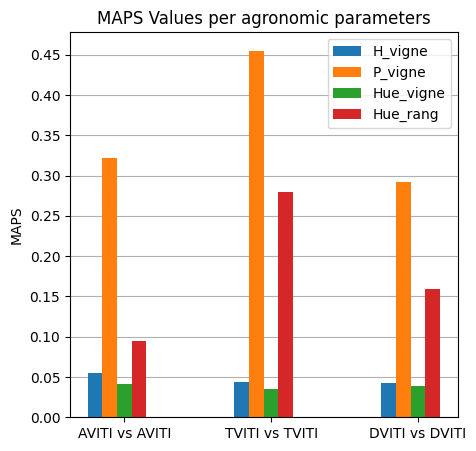

In [ ]:
cats = ["AVITI vs AVITI", "TVITI vs TVITI", "DVITI vs DVITI"] # categories

vals_h_vigne = [pertinence_res_timeseries_field.loc["MAPE", c][0] for c in cats]
vals_p_vigne = [pertinence_res_timeseries_field.loc["MAPE", c][1] for c in cats]
vals_Hue_vigne = [pertinence_res_timeseries_field.loc["MAPE", c][2] for c in cats]
vals_Hue_rang = [pertinence_res_timeseries_field.loc["MAPE", c][3] for c in cats]

# Bar width and x locations
w, x = 0.1, np.arange(len(cats))

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(x - 0.2, vals_h_vigne, width=w, label='H_vigne')
ax.bar(x - 0.1, vals_p_vigne, width=w, label='P_vigne')
ax.bar(x + 0, vals_Hue_vigne, width=w, label='Hue_vigne')
ax.bar(x + 0.1, vals_Hue_rang, width=w, label='Hue_rang')

ax.grid(axis='y')
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_yticks(np.arange(0.0,0.5,0.05))
ax.set_ylabel('MAPE')
ax.set_title('MAPE Values per agronomic parameters')
ax.legend()
plt.show()

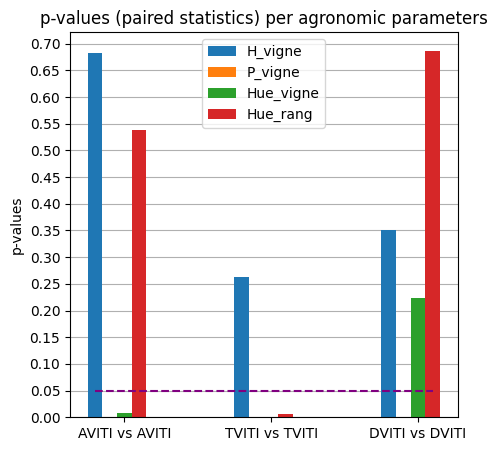

In [29]:
vals_h_vigne = [pertinence_res_timeseries_field.loc["stat_paired", c][0] for c in cats]
vals_p_vigne = [pertinence_res_timeseries_field.loc["stat_paired", c][1] for c in cats]
vals_Hue_vigne = [pertinence_res_timeseries_field.loc["stat_paired", c][2] for c in cats]
vals_Hue_rang = [pertinence_res_timeseries_field.loc["stat_paired", c][3] for c in cats]

# Bar width and x locations
w, x = 0.1, np.arange(len(cats))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hlines(0.05,-0.2,2.1, colors="purple", linestyles = "dashed")
ax.bar(x - 0.2, vals_h_vigne, width=w, label='H_vigne')
ax.bar(x - 0.1, vals_p_vigne, width=w, label='P_vigne')
ax.bar(x + 0, vals_Hue_vigne, width=w, label='Hue_vigne')
ax.bar(x + 0.1, vals_Hue_rang, width=w, label='Hue_rang')

ax.grid(axis='y')
ax.set_xticks(x)
ax.set_xticklabels(cats)
ax.set_yticks(np.arange(0.0,0.75,0.05))
ax.set_ylabel('p-values')
ax.set_title('p-values (paired statistics) per agronomic parameters')
ax.legend()
plt.show()